In [1]:
"""
Description:
    Draft code for demonstrating data-extraction and visualization of an 
    ASDF file contianing MT data
References:

CreationDate:   31/07/18
Developer:      rakib.hassan@ga.gov.au

Revision History:
    LastUpdate:     31/07/18   RH
    LastUpdate:     dd/mm/yyyy  Who     Optional description
"""

import sys, os, math
import numpy as np
import scipy
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.basemap import Basemap
from descartes import PolygonPatch
from shapely.geometry import Polygon

from collections import defaultdict
from obspy.core import inventory, Stream, UTCDateTime, read
import pyasdf
import configparser, fnmatch
import pandas as pd
import mpld3


In [2]:
# Define file-path
ASDF_PATH = '/g/data1a/ha3/rakib/ausLAMP/Data/Output/au.vic.h5'

## Open ASDF file in read-mode

In [3]:

ds = pyasdf.ASDFDataSet(ASDF_PATH, mode='r')

## Fetch all Station Coordinates from ASDF File

In [4]:
coordsDict = ds.get_all_coordinates()


## Plot Stations

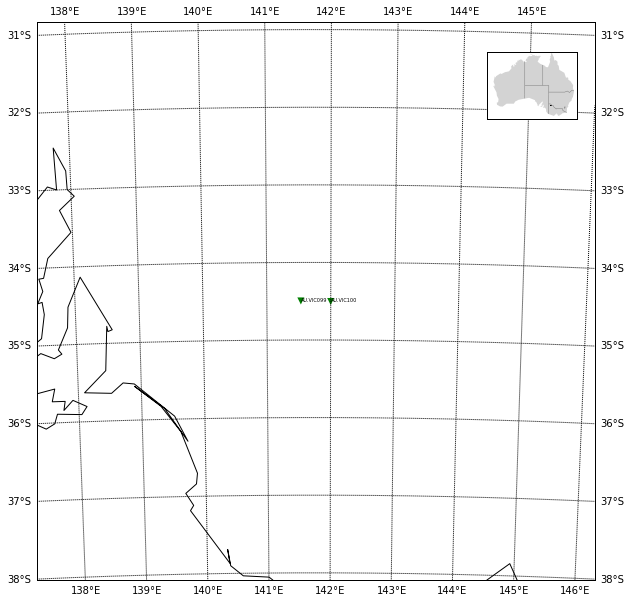

In [5]:

def drawBBox( minLon, minLat, maxLon, maxLat, bm, **kwargs):
    bblons = np.array([minLon, maxLon, maxLon, minLon, minLon])
    bblats = np.array([minLat, minLat, maxLat, maxLat, minLat])
    
    x, y = bm( bblons, bblats )
    xy = zip(x,y)
    poly = Polygon(xy)
    bm.ax.add_patch(PolygonPatch(poly, **kwargs))
#end func

fig = plt.figure(figsize=(10,10))

minLon = 1e32
maxLon = -1e32
minLat = 1e32
maxLat = -1e32
for k in coordsDict.keys():
    coords = coordsDict[k]
    lon,lat = coords['longitude'], coords['latitude'], 
    
    if(minLon > lon): minLon = lon
    if(maxLon < lon): maxLon = lon
    if(minLat > lat): minLat = lat
    if(maxLat < lat): maxLat = lat        
# end for

m = Basemap(width=800000,height=800000,projection='lcc',
            resolution='l',lat_1=minLat,lat_2=maxLat,
            lat_0=(minLat+maxLat)/2., lon_0=(minLon + maxLon)/2.)
# draw coastlines.
m.drawcoastlines()

#draw grid
parallels = np.linspace(np.floor(minLat)-5, np.ceil(maxLat)+5, \
                        int((np.ceil(maxLat)+5) - (np.floor(minLat)-5))+1)
m.drawparallels(parallels,labels=[True,True,False,False])
meridians = np.linspace(np.floor(minLon)-5, np.ceil(maxLon)+5, \
                        int((np.ceil(maxLon)+5) - (np.floor(minLon)-5))+1)
m.drawmeridians(meridians,labels=[False,False,True,True])


# plot stations
for k in coordsDict.keys():
    coords = coordsDict[k]
    lon,lat = coords['longitude'], coords['latitude'], 

    px,py = m(lon, lat)
    pxl,pyl = m(lon, lat-0.1)
    m.scatter(px, py, 50, marker='v', c='g', edgecolor='none')    
    plt.annotate(k, xy=(px, py), fontsize=5)
# end for

insetAx = fig.add_axes([0.75,0.75,0.125,0.125])
mInset = Basemap(resolution='c', # c, l, i, h, f or None
            ax=insetAx,
            projection='merc',
            lat_0=-20, lon_0=132,
            llcrnrlon=110, llcrnrlat=-40, urcrnrlon=155, urcrnrlat=-10)
#mInset.drawcoastlines()
mInset.fillcontinents(color='lightgray')
mInset.drawstates(color="grey")

drawBBox(minLon, minLat, maxLon, maxLat, mInset, fill='True', facecolor='k')

plt.savefig('stations.pdf')


## Define Query Parameters, Fetch Data and Plot Them

In [20]:
network   = 'AU'
stations   = ['VIC099', 'VIC100']
location  = '*'
channel   = '*'
starttime = '2014-07-14T00:00:00.00'
endtime   = '2014-08-01T00:00:00.00'

streamDict = defaultdict(list)

for station in stations:
    streamDict[station] = ds.get_waveforms(network, station, location, 
                                           channel, starttime, endtime, tag="raw_recording")
# end for    

In [21]:
# Calibration parameters
bz_adjust = 2.2
mult = 1e7
gainB = gainE = 1.
gainEOnly = 10.
someFactor = 7e4
xlength=50
ylength=50
declination=10

channelScalars = {'bx':(1./mult)*someFactor*gainB,
                  'by':(1./mult)*someFactor*gainB,
                  'bz':(1./mult)*someFactor*gainB*bz_adjust,
                  'ex':(1./xlength)*gainE/gainEOnly,
                  'ey':(1./ylength)*gainE/gainEOnly,
                  'tp':1.}

calibratedStreamDict = defaultdict(list)
for sk in streamDict.keys():
    stream = streamDict[sk]
    # Calibrate data
    tracesDict = defaultdict(list)
    for tr in stream: tracesDict[tr.stats.channel] = tr

    for k in channelScalars.keys():
        tracesDict[k].data = tracesDict[k].data * channelScalars[k]
        print tracesDict[k]
    # end for

    # Rotate e-channels
    trEx, trEy = tracesDict['ex'], tracesDict['ey']
    trExCopy = trEx.copy()
    trEyCopy = trEy.copy()

    trExCopy.data = -(trEx.data*np.cos(-declination/180.0*np.pi) + 
                      trEy.data*np.sin(-declination/180.0*np.pi))
    trEyCopy.data = -(trEy.data*np.cos(-declination/180.0*np.pi) - 
                      trEx.data*np.sin(-declination/180.0*np.pi))                            

    tracesDict['ex'] = trExCopy
    tracesDict['ey'] = trEyCopy

    newStream = Stream()
    for k in sorted(channelScalars.keys())[:-1]:
        tracesDict[k].detrend()
        newStream += tracesDict[k]
    # end for
    calibratedStreamDict[sk] = newStream
# end for

AU.VIC100.Su.tp | 2014-07-14T00:00:00.000000Z - 2014-07-29T14:55:59.900000Z | 10.0 Hz, 13497600 samples
AU.VIC100.Su.ey | 2014-07-14T00:00:00.000000Z - 2014-07-29T14:55:59.900000Z | 10.0 Hz, 13497600 samples
AU.VIC100.Su.ex | 2014-07-14T00:00:00.000000Z - 2014-07-29T14:55:59.900000Z | 10.0 Hz, 13497600 samples
AU.VIC100.Su.bx | 2014-07-14T00:00:00.000000Z - 2014-07-29T14:55:59.900000Z | 10.0 Hz, 13497600 samples
AU.VIC100.Su.by | 2014-07-14T00:00:00.000000Z - 2014-07-29T14:55:59.900000Z | 10.0 Hz, 13497600 samples
AU.VIC100.Su.bz | 2014-07-14T00:00:00.000000Z - 2014-07-29T14:55:59.900000Z | 10.0 Hz, 13497600 samples
AU.VIC099.Fl.tp | 2014-07-14T00:00:00.000000Z - 2014-07-29T07:06:59.900000Z | 10.0 Hz, 13216200 samples
AU.VIC099.Fl.ey | 2014-07-14T00:00:00.000000Z - 2014-07-29T07:06:59.900000Z | 10.0 Hz, 13216200 samples
AU.VIC099.Fl.ex | 2014-07-14T00:00:00.000000Z - 2014-07-29T07:06:59.900000Z | 10.0 Hz, 13216200 samples
AU.VIC099.Fl.bx | 2014-07-14T00:00:00.000000Z - 2014-07-29T07:06

# Plot Data for VIC099 over 2 weeks

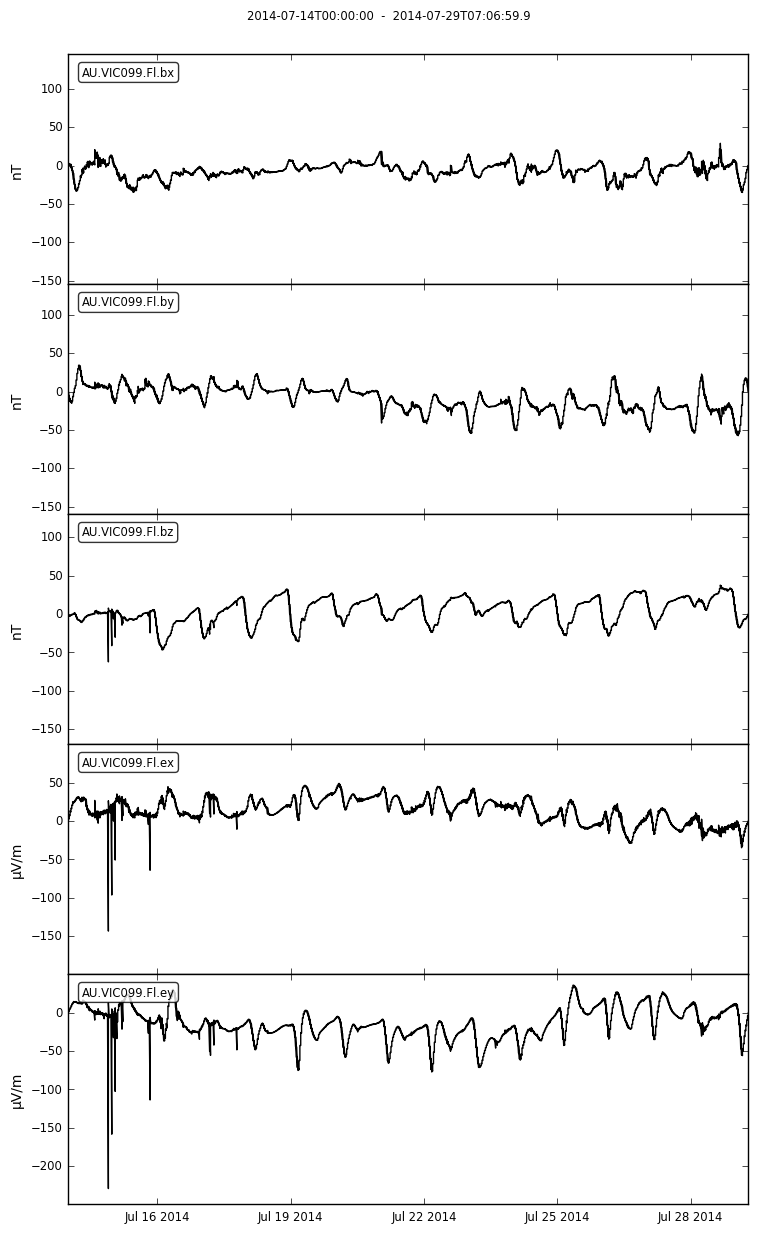

In [23]:
# plot data for vic099
mpld3.enable_notebook()
f = calibratedStreamDict['VIC099'].plot(automerge=False, handle=True)

for a in f.axes[0:3]: a.set_ylabel('nT')
for a in f.axes[3:]: a.set_ylabel(u'µV/m')    

# Plot Bx Channel for VIC099 and VIC100

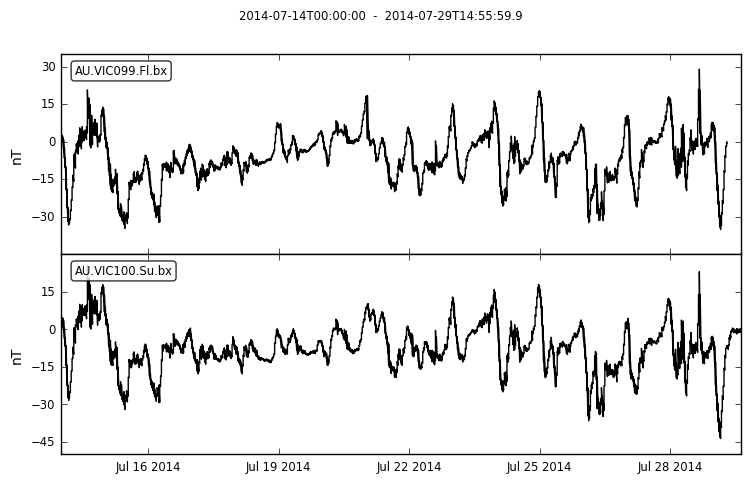

In [26]:
bxFromTwoStations = Stream()

bxFromTwoStations += calibratedStreamDict['VIC099'].traces[0]
bxFromTwoStations += calibratedStreamDict['VIC100'].traces[0]

f = bxFromTwoStations.plot(automerge=False, handle=True)

for a in f.axes[0:3]: a.set_ylabel('nT')


# Plot Spectrograms (1-day) for all Components of VIC099

AU.VIC100.Su.ey | 2014-07-16T00:00:00.000000Z - 2014-07-17T00:59:59.900000Z | 10.0 Hz, 900000 samples


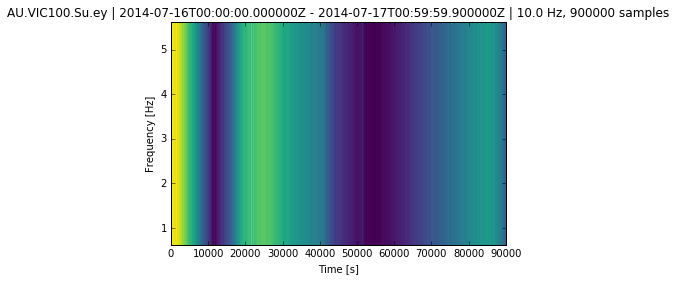

AU.VIC100.Su.ex | 2014-07-16T00:00:00.000000Z - 2014-07-17T00:59:59.900000Z | 10.0 Hz, 900000 samples


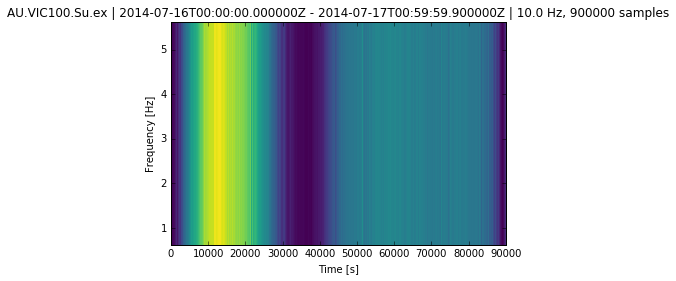

AU.VIC100.Su.bz | 2014-07-16T00:00:00.000000Z - 2014-07-17T00:59:59.900000Z | 10.0 Hz, 900000 samples


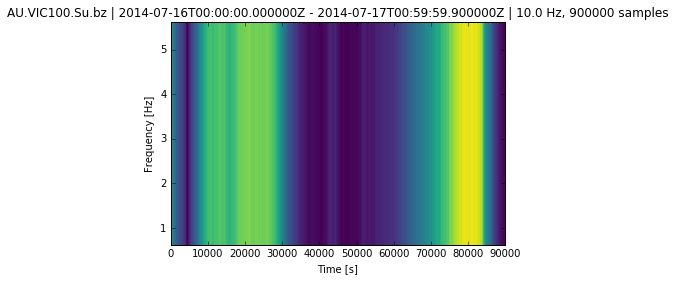

AU.VIC100.Su.bx | 2014-07-16T00:00:00.000000Z - 2014-07-17T00:59:59.900000Z | 10.0 Hz, 900000 samples


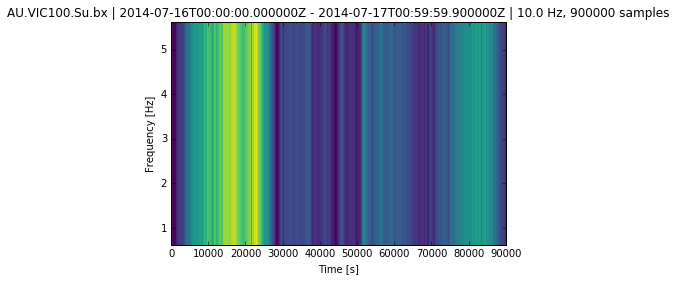

AU.VIC100.Su.by | 2014-07-16T00:00:00.000000Z - 2014-07-17T00:59:59.900000Z | 10.0 Hz, 900000 samples


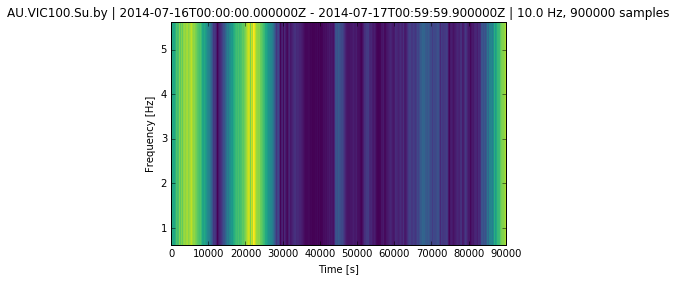

AU.VIC100.Su.tp | 2014-07-16T00:00:00.000000Z - 2014-07-17T00:59:59.900000Z | 10.0 Hz, 900000 samples


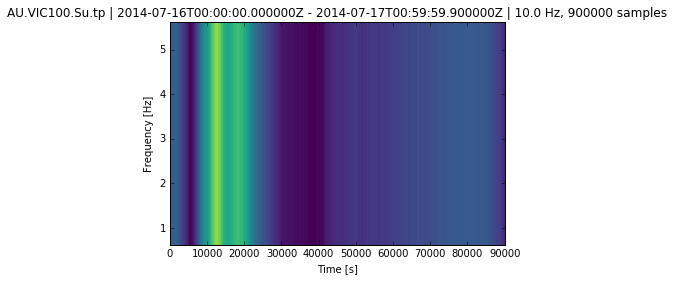

In [28]:
mpld3.disable_notebook()
starttime = '2014-07-16T00:00:00.00'
endtime   = '2014-07-17T00:00:00.00'

dayStream = ds.get_waveforms(network, station, location, channel, starttime, endtime, tag="raw_recording")

for t in dayStream:
    print t
    t.spectrogram()